In [34]:
from mlxtend.classifier import StackingCVClassifier
import numpy as np
import pandas as pd
import sys, os, glob
import imp
import seaborn as sns
sys.path.append('./src/')
import common_utils,my_ensembler, feature_utils, defines, model_utils, my_bert
from sklearn.neighbors import KNeighborsClassifier
from sklearn_crfsuite import scorers, CRF
from sklearn.pipeline import Pipeline
import json
from operator import itemgetter
from sklearn_crfsuite.utils import flatten
from sklearn_crfsuite.metrics import sequence_accuracy_score
from sklearn.linear_model import LogisticRegression
import scipy
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
import classes
import pickle
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import re
from sklearn.metrics import PrecisionRecallDisplay
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin, MetaEstimatorMixin, ClassifierMixin
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, PassiveAggressiveClassifier, Perceptron, RidgeClassifier, RidgeClassifierCV, SGDClassifier


In [27]:
dir_name='duplicate'
final_pred_name='merged.crf.bert.ens.c.w.l'
final_feature_name='local.plot.tfidf.30'
cv_split_name='cv_splits_per_client'


In [29]:
all_pred_crf01=common_utils.load_db(dir_name,final_pred_name)
local_plot=common_utils.load_db(dir_name,final_feature_name)
cv_splits_loaded=common_utils.load_json(dir_name,cv_split_name)

Opened /scratch/sim_reg9/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/merged.crf.bert.ens.c.w.l.csv,  index False
Opened /scratch/sim_reg9/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/local.plot.tfidf.30.csv,  index False
Opened /scratch/sim_reg9/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/cv_splits_per_client.json


### Open GridSearch

In [22]:
# SGDClassifier(
#     loss='log',
#     penalty='l1',
#     alpha=0.0001
#     )

In [72]:
grid_search_clf=common_utils.load_pickle(dir_name,'grid_search_clf.SGD.th.20')

EOFError: Ran out of input

init >> MyGrid


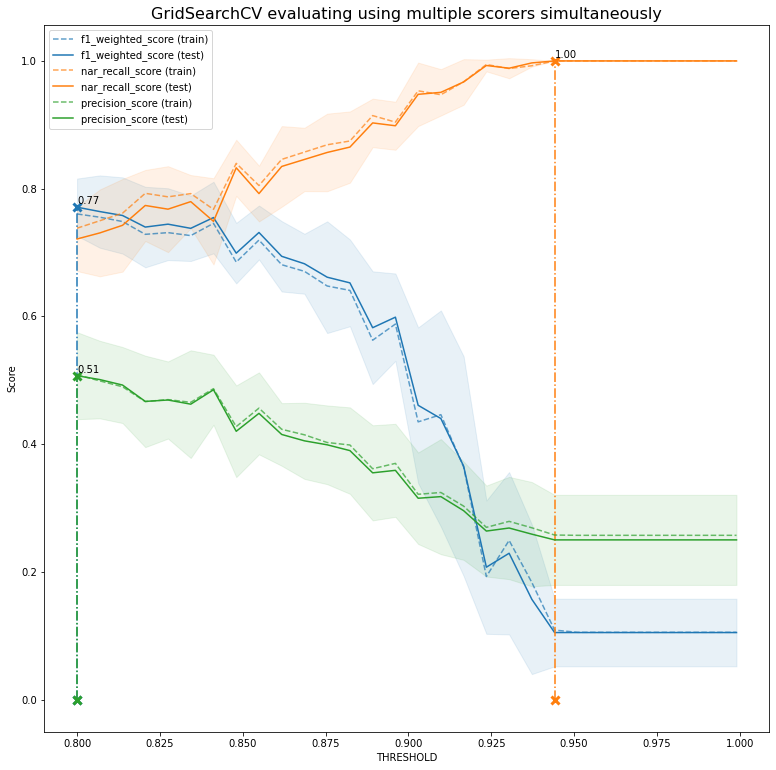

In [69]:
imp.reload(classes)
myGrid=classes.MyGrid()
myGrid.plot(grid_search_clf,'thresholdclassifier__threshold',['nar_recall_score','f1_weighted_score','precision_score'])

## Use best ensembler found by GridSearch

In [73]:
ens_predictions=model_utils.prepared_cross_validate_ensemble(
    SGDClassifier(
                        loss='log_loss',
                        penalty='l1',
                        alpha=0.0001
                        ),
    all_pred_crf01,
    cv_splits_loaded)

0 split started...
1 split started...
2 split started...
3 split started...
4 split started...
5 split started...
6 split started...
7 split started...


In [79]:
all_pred_crf01['bert_true'].value_counts(normalize=True)

0    0.74356
1    0.25644
Name: bert_true, dtype: float64

In [81]:
pos_ratio=all_pred_crf01['bert_true'].value_counts(normalize=True)[1]
pos_ratio

0.2564396107613051

In [102]:
report_th=classes.MyScoreSummarizer(pred_df=all_pred_crf01,
                                      fix_list=[
                                               'threshold_{}'.format(pos_ratio),
                                      ],
                                      prefixes=['ens'])
report_th.get_all_scores('split')
report_th.print_df['ens'].index.name='label'
with pd.option_context('display.float_format', '{:0.3f}'.format):
    display(report_th.print_df['ens'])

MyScoreSummarizer init called
MyPredFixer init called
WindowDiff init called
Total pos 6501 ens before using threshold 0.2564396107613051
Total pos 7934 ens after  using threshold 0.2564396107613051
ens
MyReport init called


,sent_f1,fixed_f1,sent_recall,fixed_recall,sent_prec,fixed_prec
label,,,,,,
0,0.878,0.873,0.932,0.907,0.830,0.843
1,0.513,0.548,0.419,0.484,0.694,0.654
weighted avg,0.792,0.798,0.809,0.807,0.800,0.800


In [116]:
report_th.my_fixer.stat['ens']

{'pos_pred_0.5': 6501,
 'total_fp': 2077,
 'total_fn': 5432,
 'near': {'tot': 156, 'fp': 42, 'fn': 114}}

In [108]:
common_utils.save_db(report_th.fixed_df,dir_name,'all_pred.threshold{:.3f}'.format(pos_ratio))

Saving /scratch/sim_reg9/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/all_pred.threshold0.256.csv, 
index False
float_format %.5f


In [105]:
report_th_smoothed=classes.MyScoreSummarizer(pred_df=all_pred_crf01,
                                      fix_list=['threshold_{}'.format(pos_ratio),
                                               'near_miss',
                                               'single_miss',
                                               'single_sa'],
                                      prefixes=['ens'])
report_th_smoothed.get_all_scores('split')
report_th_smoothed.print_df['ens'].index.name='label'
with pd.option_context('display.float_format', '{:0.3f}'.format):
    display(report_th_smoothed.print_df['ens'])

MyScoreSummarizer init called
MyPredFixer init called
WindowDiff init called
Total pos 6501 ens before using threshold 0.2564396107613051
Total pos 7934 ens after  using threshold 0.2564396107613051
near misses to be fixed
 {'tot': 156, 'fp': 42, 'fn': 114}
488 middle misses to be fixed
276 stande alone to be fixed
ens
MyReport init called


,sent_f1,fixed_f1,sent_recall,fixed_recall,sent_prec,fixed_prec
label,,,,,,
0,0.878,0.876,0.932,0.905,0.830,0.849
1,0.513,0.567,0.419,0.508,0.694,0.663
weighted avg,0.792,0.804,0.809,0.812,0.800,0.806


In [122]:
my_rep=classes.MyPredFixer(pred_df=report_th_smoothed.fixed_df, fix_list=['threshold_{}'.format(pos_ratio),
                                               'near_miss',
                                               'single_miss',
                                               'single_sa'],
                           prefixes=['bert','crf','ens'])
my_rep.get_stat_for_prefixes(my_rep.prefixes)

MyPredFixer init called
WindowDiff init called
bert
crf
ens


In [124]:
pd.DataFrame(my_rep.stat)

,bert,crf,ens
pos_pred_0.5,10796,7990,8210
unique,5743,3915,NaN
false_neg_unique,1659,2148,NaN
false_pos_unique,4084,1767,NaN
total_fp,5434,3117,2895
total_fn,4494,4983,4541
near,"{'tot': 336, 'fp': 163, 'fn': 173}","{'tot': 50, 'fp': 27, 'fn': 23}","{'tot': 109, 'fp': 85, 'fn': 24}"
mid,1860,2,0
mid_orig,915,2,0
stand_alone,691,6,0


In [111]:
report_th_smoothed.print_df['ens'].to_csv(sep='&',line_terminator='\\ \hline',float_format='%.3f')

'"label"&"sent_f1"&"fixed_f1"&"sent_recall"&"fixed_recall"&"sent_prec"&"fixed_prec"\\ \\hline0&0.878&0.876&0.932&0.905&0.830&0.849\\ \\hline1&0.513&0.567&0.419&0.508&0.694&0.663\\ \\hline"weighted avg"&0.792&0.804&0.809&0.812&0.800&0.806\\ \\hline'

In [107]:
common_utils.save_db(report_th_smoothed.fixed_df,dir_name,'all_pred_fixed.threshold{:.3f}'.format(pos_ratio))

Saving /scratch/sim_reg9/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/all_pred_fixed.threshold0.256.csv, 
index False
float_format %.5f


# Undersample: compare full sample BERT vs underamble BERT

In [6]:
bert_compare=common_utils.load_db(dir_name,'bert.comparison.usampl')

Opened /scratch/sim_reg9/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/bert.comparison.usampl.csv,  index False


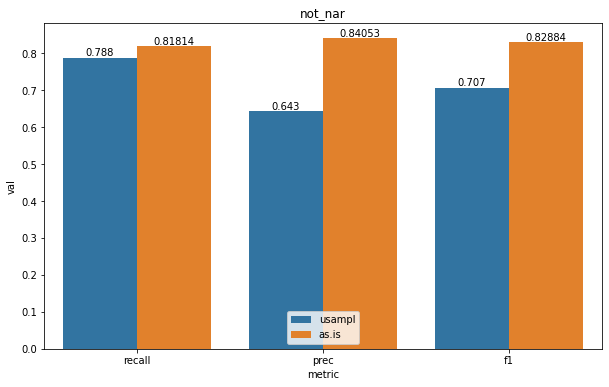

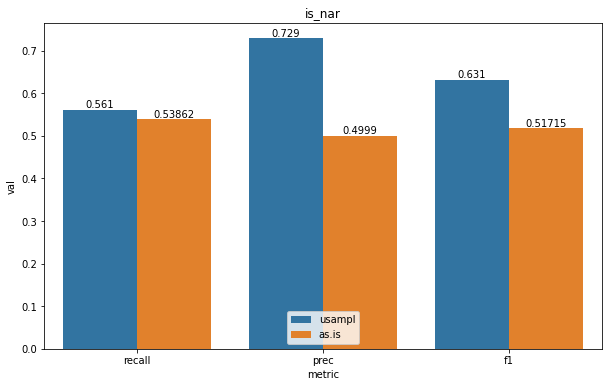

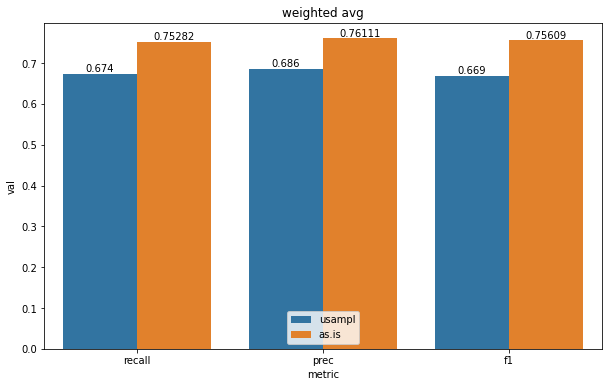

In [7]:
common_utils.plot_accumulated_db(bert_compare)

# Undersample: compare full sample CRF vs underamble CRF

Opened /scratch/sim_reg9/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/crf.comparison.usampl.csv,  index False


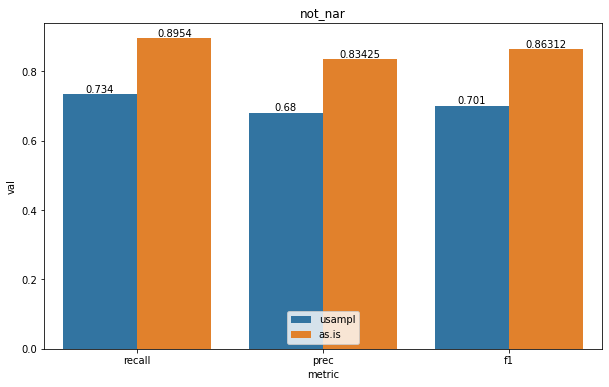

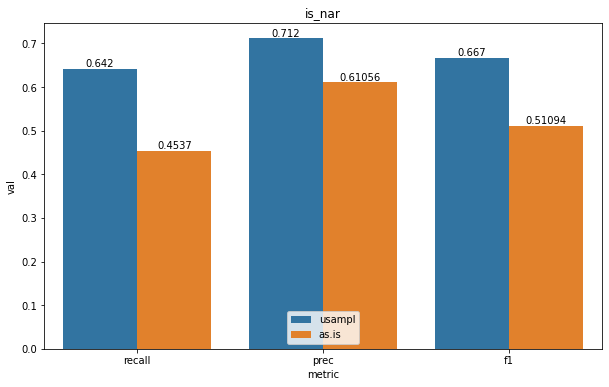

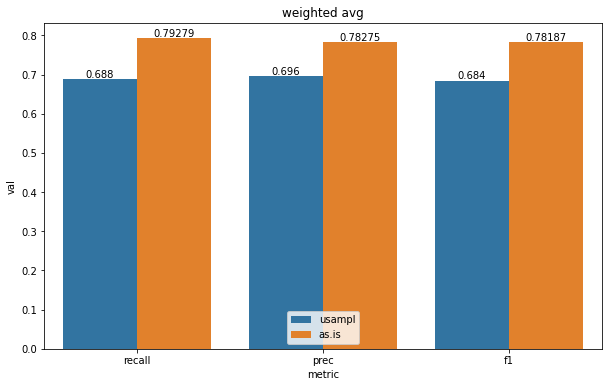

In [9]:
crf_compare=common_utils.load_db(dir_name,'crf.comparison.usampl')
common_utils.plot_accumulated_db(crf_compare)

# Undersample: compare full sample ensemble vs underamble ensemble

Opened /scratch/sim_reg9/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/ens.comparison.usampl.csv,  index False


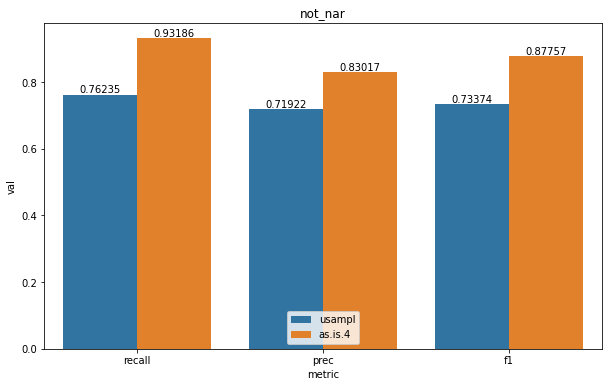

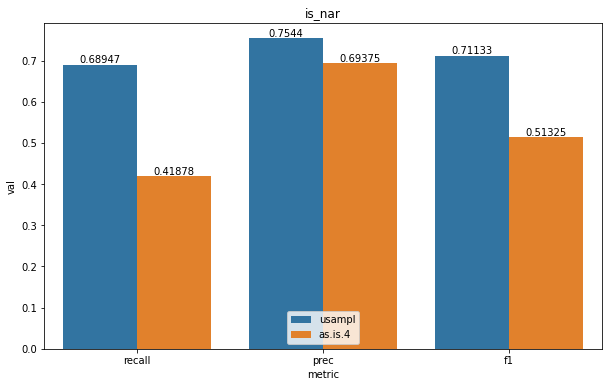

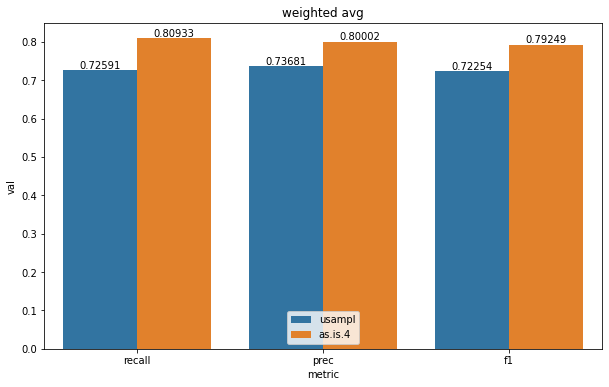

In [10]:
ens_compare=common_utils.load_db(dir_name,'ens.comparison.usampl')
common_utils.plot_accumulated_db(ens_compare)

# Threshold: compare ensemble performance on threshold 0.5 vs ensemble on threshold 0.17

Opened /scratch/sim_reg9/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/ens.fixed.comparison.threshold.csv,  index False


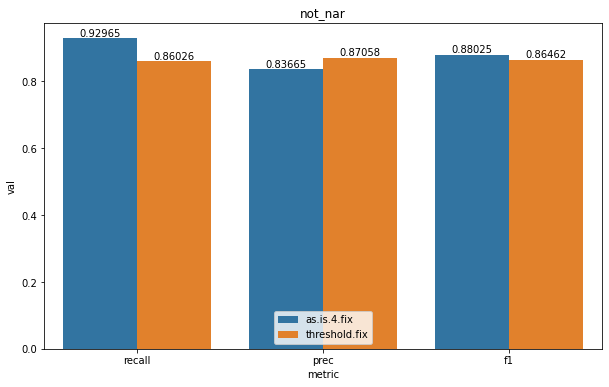

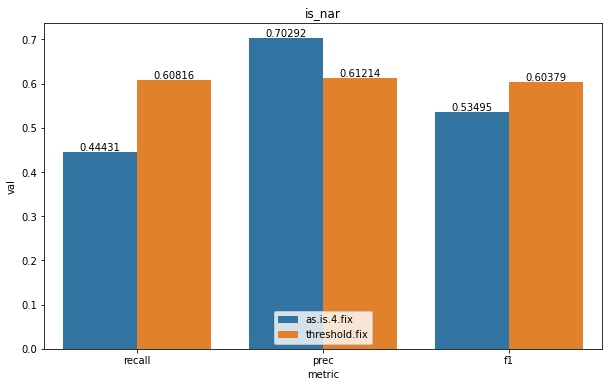

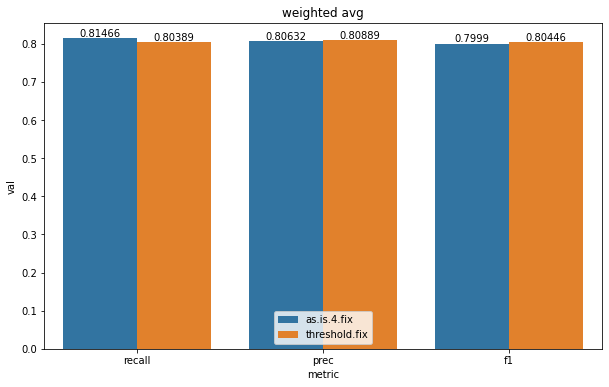

In [14]:
ens_fix_compare=common_utils.load_db(dir_name,'ens.fixed.comparison.threshold')
common_utils.plot_accumulated_db(ens_fix_compare)

# Plot precision-recall curve

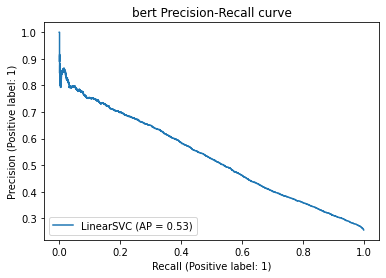

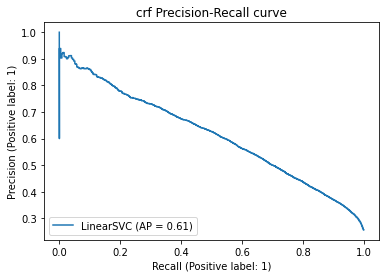

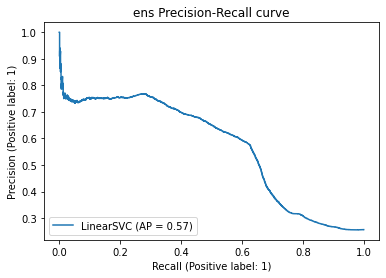

In [14]:
from sklearn.metrics import PrecisionRecallDisplay

for t in ['bert','crf','ens']:
    y_test=all_pred_crf01['{}_true'.format(t)].tolist()
    y_score=all_pred_crf01['{}_proba_1'.format(t)].tolist()

    display = PrecisionRecallDisplay.from_predictions(y_test, y_score, name="LinearSVC")
    _ = display.ax_.set_title("{} Precision-Recall curve".format(t))

# Plot ROC curve

Best Threshold=0.389610, G-Mean=0.677


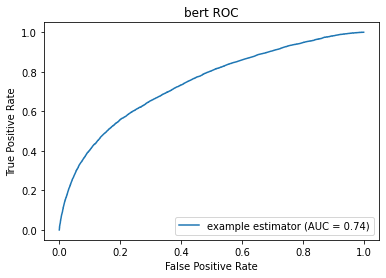

Best Threshold=0.203000, G-Mean=0.730


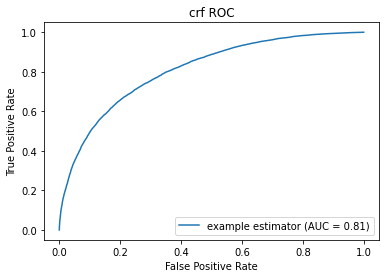

Best Threshold=0.159640, G-Mean=0.726


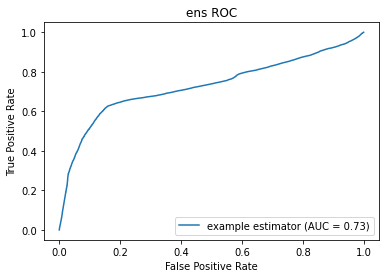

In [15]:
for t in ['bert','crf','ens']:
    y_test=all_pred_crf01['{}_true'.format(t)].tolist()
    y_score=all_pred_crf01['{}_proba_1'.format(t)].tolist()
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                       estimator_name='example estimator')
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
    display.plot()
    plt.title('{} ROC'.format(t))
    plt.show()

# Plot important features - narrative label

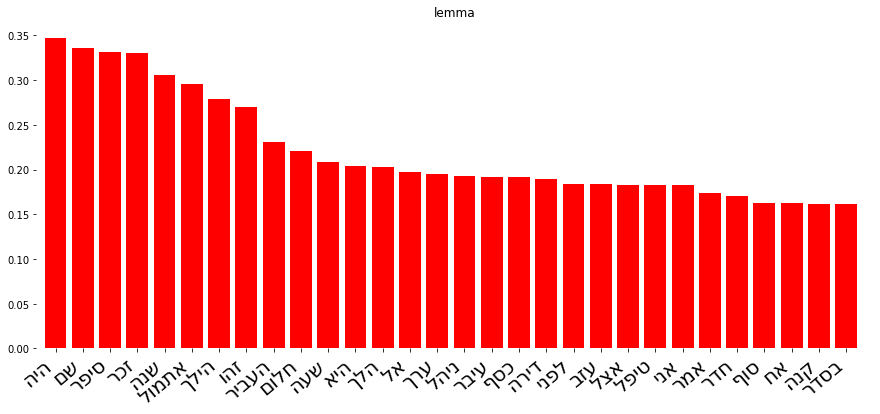

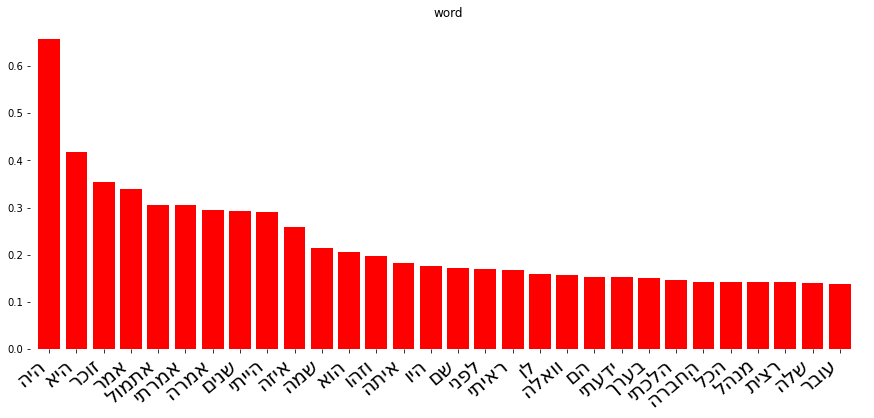

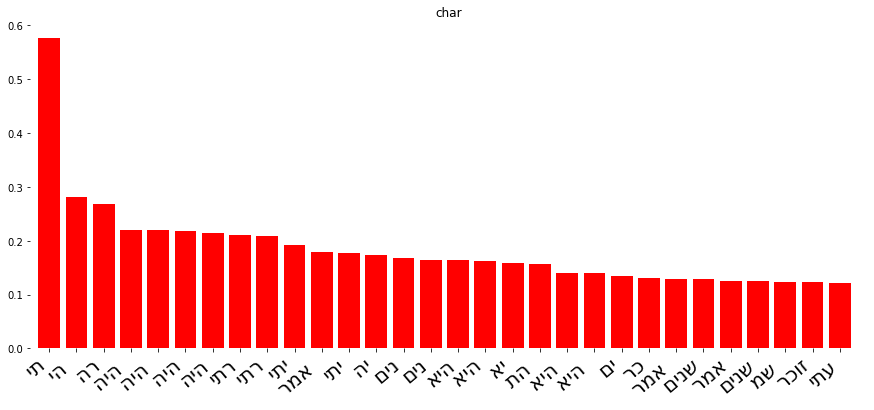

In [18]:
imp.reload(model_utils)
for tt in ['lemma','word','char']:
    plt.figure(figsize=(15, 6))
    ax=model_utils.plot_important_features(tt,local_plot['weight.{}.is_nar'.format(tt)].tolist(), local_plot['string.{}.is_nar'.format(tt)].tolist(), top_n=30, rotation=40)
    plt.show()

# Plot important features - non-narrative label

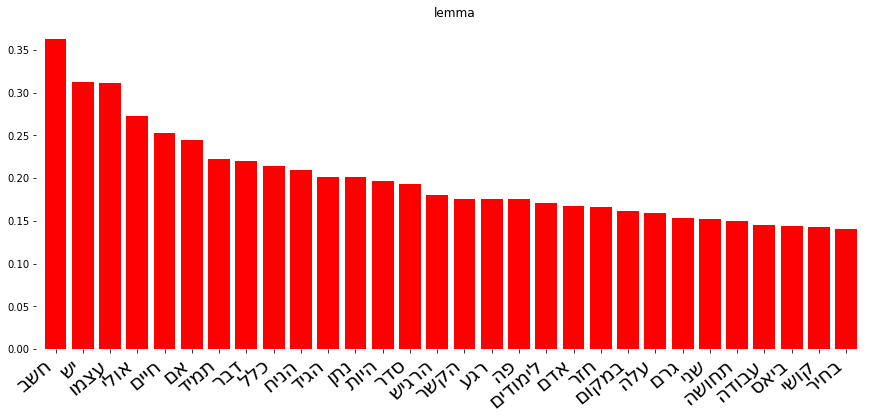

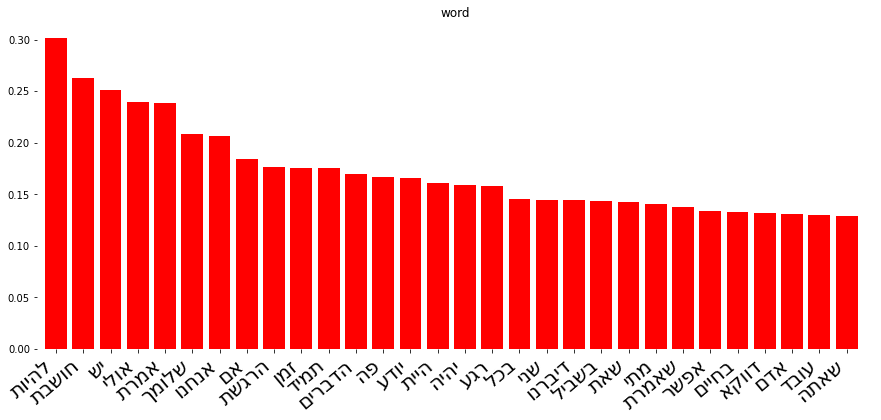

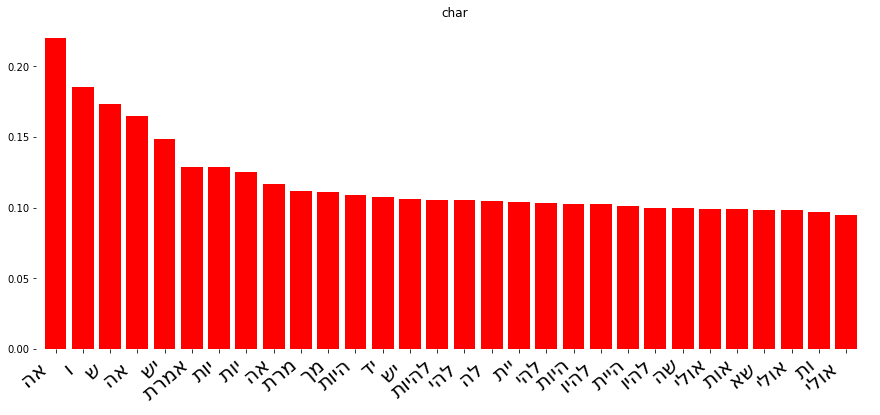

In [22]:
for tt in ['lemma','word','char']:
    plt.figure(figsize=(15, 6))
    ax=model_utils.plot_important_features(tt,local_plot['weight.{}.not_nar'.format(tt)].tolist(), local_plot['string.{}.not_nar'.format(tt)].tolist(), top_n=30, rotation=40)
    plt.show()